In [1]:
# Base Libraries
import time
import datetime
import os
import re

# Scientific libraries
import pandas as pd
import numpy as np
from pandas.core.interchange.dataframe_protocol import DataFrame
from scipy.stats import alpha
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Visual libraries
import seaborn as sns
from seaborn import objects as so
import matplotlib.pyplot as plt
from sklearn.utils.estimator_checks import estimator_checks_generator

print("Set up complete")

Set up complete


# 1. Data Preparation

In [3]:
procDataPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AllFishCombined_unfiltered.csv"
#
# procAnaPath = "C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/processed_AnalysisData.csv"

proc_data = pd.read_csv(procDataPath, parse_dates=True)

# proc_ana = pd.read_csv(procAnaPath, parse_dates=True)
print("Reading complete")

C:\Users\86139\AppData\Local\Temp\ipykernel_17760\983152940.py:5: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  proc_data = pd.read_csv(procDataPath, parse_dates=True)


Reading complete


In [5]:
## Subset EDA, Training, and Validation data
burbotCount = 1
lakeTroutCount = 12
lakeWhiteFishCount = 8
smallMouthBassCount = 8

## Predixes
burbotPr = "BUR"
lakeTroutPr = "LT"
lakeWhiteFishPr = "LWF"
smallMouthBassPr = "SMB"


## Generate the fishNum
def makeFishNum(prefix, count):
    """
    Computes an array of fish numbers, in format like "LWF001", "LWF012"
    :param prefix: a string of character in length 2 or 3, all capitalized
    :param count: an integer
    :return: a list of strings that represent fish numbers, count from 001 to 00n
    """
    countSeq = list(range(count+1))[1:]
    fishNum = [prefix + (3-len(str(c)))*"0" + str(c) for c in countSeq]
    return fishNum
burbotNum = makeFishNum("BUR", burbotCount)
lakeTroutNum = makeFishNum("LT", lakeTroutCount)
lakeWhiteFishNum = makeFishNum("LWF", lakeWhiteFishCount)
smallMouthBassNum = makeFishNum("SMB", smallMouthBassCount)

In [6]:
# Subset desired rows from original datasets as dataset for EDA
edaFishNum = burbotNum + lakeTroutNum + lakeWhiteFishNum + smallMouthBassNum
edaData = proc_data.loc[proc_data.fishNum.isin(edaFishNum),]

# The rest will be held out as test set
testData = proc_data.loc[~proc_data.fishNum.isin(edaFishNum),]

In [152]:
## Save the training and Test Set to csv
edaData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaData.csv")
testData.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/testData.csv")

In [ ]:
physicalVar = ["species", "sex", "totalLength", "forkLength", "weight", "girth", "dorsoLatHeight", "mat", "airbladderTotalLength", "airBladderWidth", "airbladderWeight", "airBladderWeightCond"]
edaPhy = edaData[["fishNum"] + physicalVar]

edaPhyDtype = edaPhy.dtypes
edaNaCount = edaPhy.isnull().sum()
pd.DataFrame({"Type": edaPhyDtype, "Missing-Count": edaNaCount})

,Type,Missing-Count
fishNum,object,0
species,object,0
totalLength,int64,0
forkLength,float64,288
weight,int64,0
girth,int64,0
dorsoLatHeight,int64,0
sex,object,0
mat,int64,0
airbladderTotalLength,int64,0


In [10]:
allFreq = [col for col in proc_data.columns if re.match(r'^F\d+', col)]
edaFreq = edaData[["fishNum"] + allFreq]
edaFreqSmry = edaFreq.groupby("fishNum").apply(lambda x: x.isnull().sum())
edaFreqSmry.head()

C:\Users\86139\AppData\Local\Temp\ipykernel_17760\1947936896.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  edaFreqSmry = edaFreq.groupby("fishNum").apply(lambda x: x.isnull().sum())


,fishNum,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
LT004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


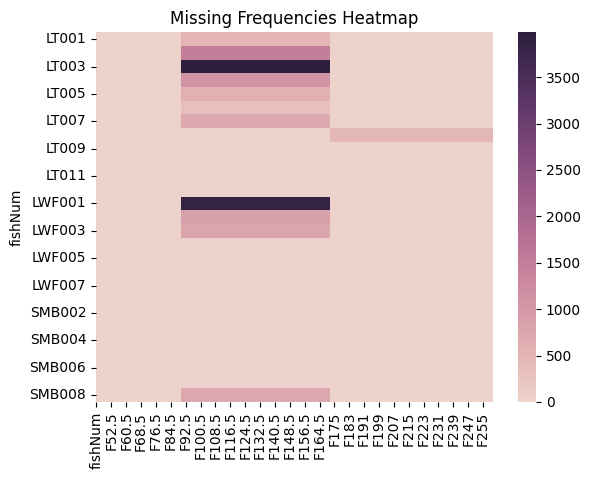

In [158]:
sns.heatmap(edaFreqSmry[1:], 
            cmap=sns.cubehelix_palette(as_cmap=True), 
            linewidth=0)
plt.title("Missing Frequencies Heatmap")
plt.show()

In [ ]:
# [var in edaData.columns.tolist() for var in physicalVar]
# edaData.columns.tolist()
edaData.loc[edaData["airbladderWeight"].isnull(), "fishNum"].unique()

array(['BUR001', 'BUR002', 'LWF003'], dtype=object)

# 2. Data Wrangling

In [7]:
## Renaming airBladder variables
edaPhy.rename({"airbladderTotalLength":"abLen", "airBladderWidth":"abWidth", "airbladderWeight":"abWeight", "airBladderWeightCond":"abWeightCond"}, axis=1, inplace=True)
edaPhy.columns

NameError: name 'edaPhy' is not defined

In [167]:
edaFreqSmry = edaFreq.groupby("fishNum").mean()
edaFreqSmry.head()

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-29.060127,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-33.118848,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.753181,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-33.244680,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.923855,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444


In [9]:
edaFreqSmry['species'] = edaData[['fishNum', 'species']].groupby("fishNum").first()
edaFreqSmry

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260,species
fishNum,,,,,,,,,,,,,,,,,,,,,
BUR001,-46.479146,-46.629557,-46.066176,-45.091633,-44.798135,-44.437357,-44.456649,-44.437115,-44.456290,-44.717498,...,-28.443539,-27.567882,-26.713292,-25.613016,-24.387497,-23.621642,-22.306471,-21.985734,-21.591365,burbot
BUR002,-51.093437,-51.122888,-51.061878,-50.517705,-50.253662,-49.785299,-49.516891,-49.249549,-49.433040,-49.961681,...,-32.880550,-31.683651,-30.946173,-30.176796,-29.134342,-28.314172,-27.109958,-26.599481,-26.088878,burbot
LT001,-46.645407,-46.367350,-46.199488,-45.653350,-45.463655,-45.166661,-45.074204,-44.997179,-44.868336,-44.747247,...,-32.515203,-32.140573,-31.557621,-30.972239,-30.231923,-29.673079,-29.033348,-28.952772,-28.955729,lakeTrout
LT002,-47.560521,-47.215797,-46.932365,-46.473483,-46.410474,-46.206567,-46.141046,-46.063951,-45.928372,-45.810265,...,-37.507503,-37.102629,-36.608307,-36.339585,-35.996327,-36.046391,-35.933225,-36.000538,-35.998340,lakeTrout
LT003,-46.168306,-45.968098,-45.782728,-45.344954,-45.274179,-45.040486,-44.923072,-44.748890,-44.548537,-44.354827,...,-32.686375,-32.061705,-31.470881,-30.837042,-30.222146,-29.694168,-28.856576,-28.702194,-28.481229,lakeTrout
LT004,-40.730473,-40.601601,-40.601523,-40.309100,-40.244519,-40.078168,-39.976723,-39.825742,-39.626494,-39.494479,...,-31.605860,-31.212022,-30.949060,-30.625302,-30.198328,-30.159049,-30.135791,-30.374540,-30.536444,lakeTrout
LT005,-60.496846,-60.252259,-60.142293,-59.752711,-59.717030,-59.492988,-59.327611,-59.181236,-59.033960,-58.906425,...,-44.419923,-44.419437,-44.427077,-44.630374,-44.598437,-44.986819,-45.202528,-45.680993,-46.040943,lakeTrout
LT006,-38.467984,-38.332608,-38.188313,-37.787999,-37.744940,-37.498326,-37.387439,-37.210920,-37.053602,-36.852407,...,-31.375899,-31.057959,-30.655594,-30.324443,-29.802385,-29.451981,-29.102356,-29.016297,-29.030183,lakeTrout
LT007,-44.213031,-44.013071,-43.864818,-43.497515,-43.414356,-43.311410,-43.464125,-43.561277,-43.450102,-43.243596,...,-33.465612,-33.238753,-32.863688,-32.678450,-32.476953,-32.545077,-32.588351,-32.863067,-32.776063,lakeTrout


# 3. Data Visualization

In [12]:
## First, we extract unique values from edaPhy
edaPhyUniq = edaPhy.groupby("fishNum").first().reset_index()

NameError: name 'edaPhy' is not defined

In [ ]:
## Plot every Physical variables in a scatter by species, exclude fish with missing values
def catPhy(df, phyVar):
    # Create the histogram
    sns.catplot(df, x="species", y=phyVar,
                hue = "species",
                palette="bright",
                alpha=0.5,
                kind = "violin")
    plt.title(f"Violin Plot of {phyVar}, Colored by Species")
    plt.xticks(rotation=45)
    # plt.show()
    plt.savefig(f"C:/Users/86139/Desktop/Images/{phyVar}.png")

def multiCatPhy(df, phyVarArray):
    for phyVar in phyVarArray:
        catPhy(df, phyVar)
    return None
physicalVar = edaPhy.columns.tolist()[2:]
# catPhy(edaPhy, "abLen")
# multiCatPhy(edaPhyUniq, physicalVar)

C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
C:\Users\86139\AppData\Local\Temp\ipykernel_20264\3304131858.py:14: UserWarning: set_ticklabels() should o

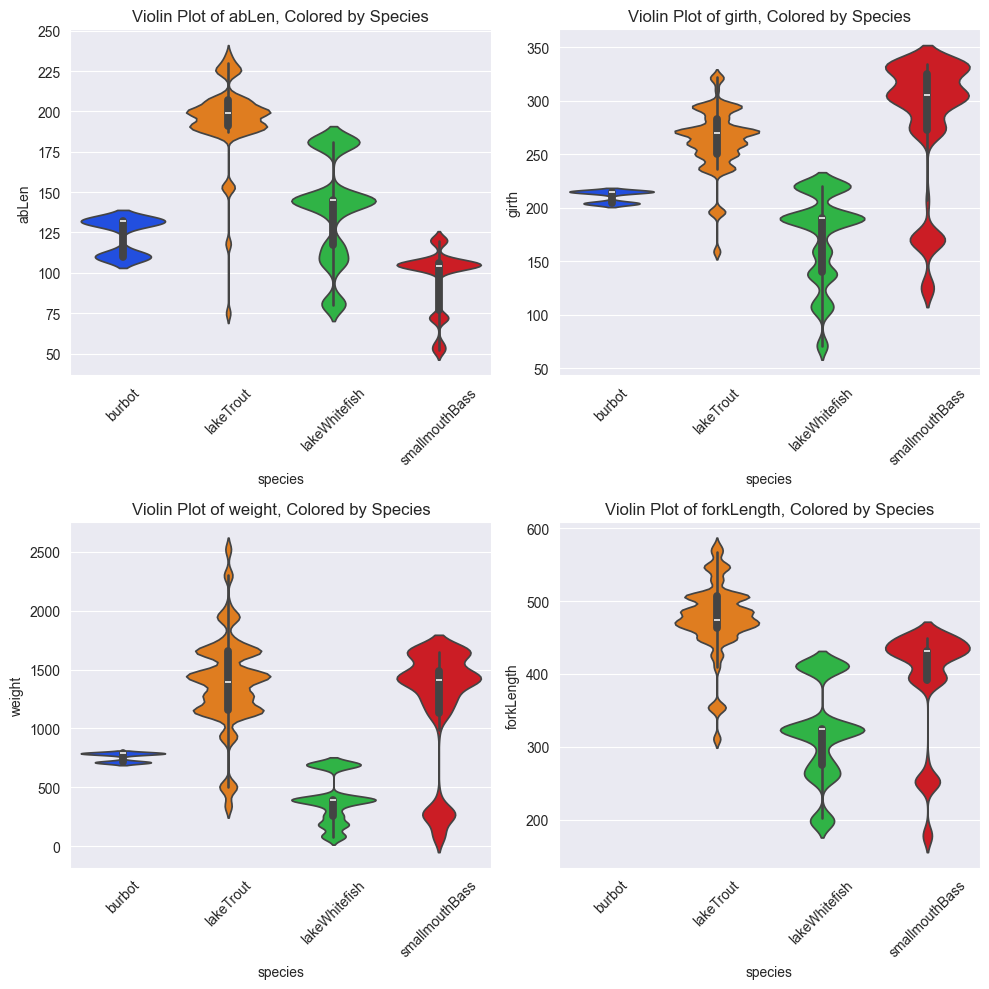

In [ ]:
## Save differential geometrics
phyDiff = ["abLen", "girth", "weight", "forkLength"]
f, axes = plt.subplots(2, 2, figsize=(10, 10))  # You can adjust the figsize as needed

# Flatten the axes array for easy iteration
axes = axes.flatten()

i = 0
for phyVar in phyDiff:
    sns.violinplot(data=edaPhy, x="species", y=phyVar, ax=axes[i],
                   hue="species",
                   palette="bright")
    axes[i].set_title(f"Violin Plot of {phyVar}, Colored by Species")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Tilt x-axis labels by 45 degrees
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
edaFreqSmry.reset_index(inplace=True)
edaFreqSmryLong = pd.melt(edaFreqSmry, id_vars = ["fishNum", "species"])
edaFreqSmryLong

,fishNum,species,variable,value
0,BUR001,burbot,F45,-46.479146
1,BUR002,burbot,F45,-51.093437
2,LT001,lakeTrout,F45,-46.645407
3,LT002,lakeTrout,F45,-47.560521
4,LT003,lakeTrout,F45,-46.168306
...,...,...,...,...
17035,SMB008,smallmouthBass,F260,-42.592962
17036,SMB009,smallmouthBass,F260,-42.517107
17037,SMB010,smallmouthBass,F260,-39.343412
17038,SMB011,smallmouthBass,F260,-37.988470


In [ ]:
edaFreqSmryLong.rename({"variable": "Freq", "value": "TS"}, axis=1, inplace=True)
edaFreqSmryLong["Freq"] = edaFreqSmryLong["Freq"].str.extract(r'(\d+)', expand=False).astype(int)
edaFreqSmryLong.groupby("species").median("TS")

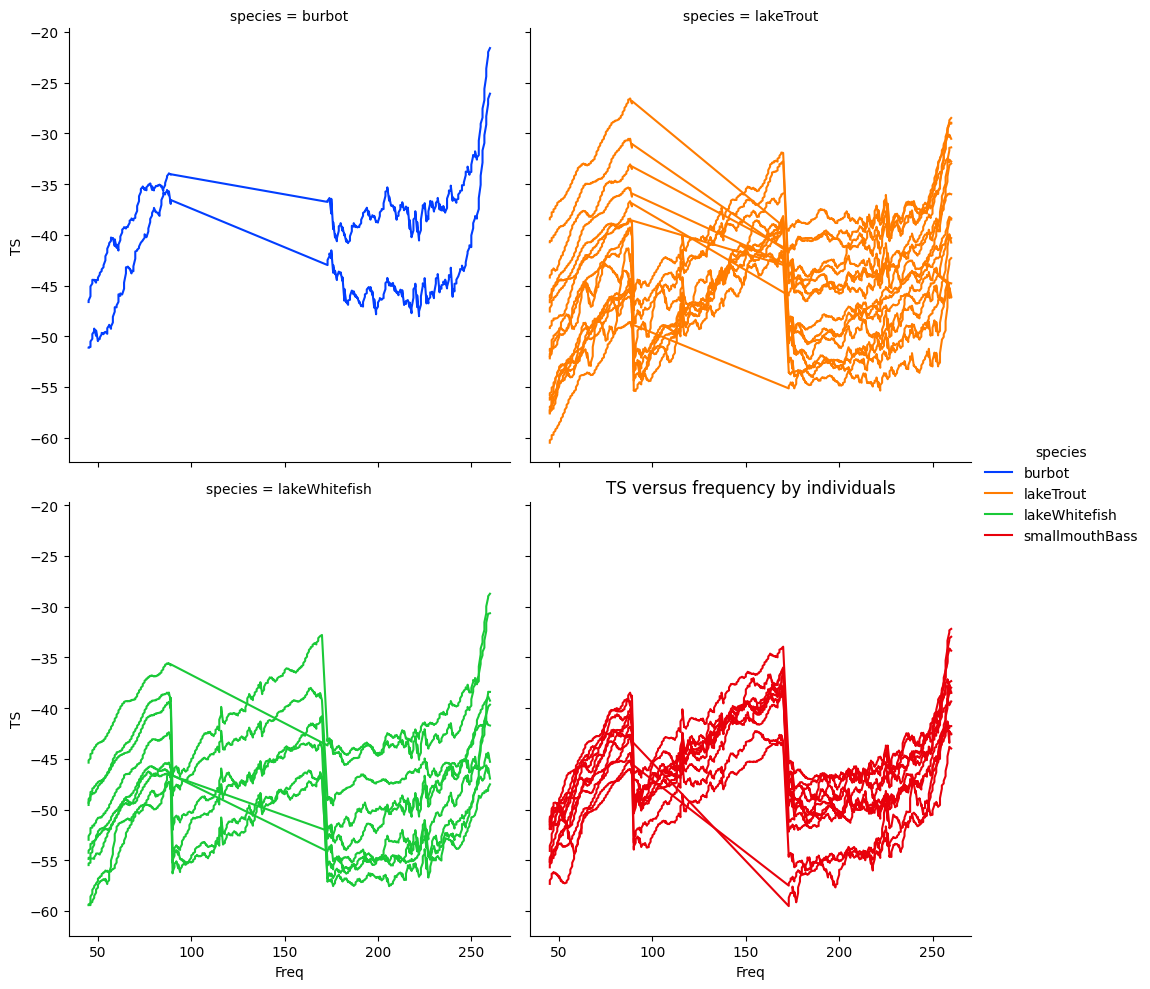

In [20]:
## Spaghetti plot for sonar frequency time
# Per each species, plot their line chart of relationships between TS and frequency, assign error bars.
# Drop rows with NA values in 'TS' column
# edaFreqSmryLong = edaFreqSmryLong.dropna(subset=['TS'])
sns.relplot(edaFreqSmryLong,  kind="line",
            x = "Freq", y="TS", units = "fishNum",
            col = "species", col_wrap = 2, hue = "species",
            palette="bright", estimator=None)
# Add titles and labels
plt.title('TS versus frequency by individuals')
plt.xlabel('Freq')
plt.ylabel('TS')
# plt.legend(loc='top')

# Show the plot
plt.show()

# 4. Model Fitting

In [ ]:
## Drop NAs in accoustic data
## Remove LT008
edaFreqSmry.set_index("fishNum", inplace=True)
edaFreqSmry.drop("LT008", axis=0, inplace = True)
# Remove all columns with any missing values
edaFreqSmry.dropna(axis=1, how="any", inplace=True)
edaFreqSmry

In [39]:
# edaFreqSmry.columns[1:].str.extract(r'(\d+)', expand=False).astype(int)
# edaFreqSmryLong.rename({"variable": "Freq", "value": "TS"}, axis=1, inplace=True)
# edaFreqSmryLong["Freq"] = edaFreqSmryLong["Freq"].str.extract(r'(\d+)', expand=False).astype(int)
# edaFreqSmryLong.groupby("species").median("TS")

# edaFreqSmryLong.head()

In [ ]:
## PCA explain the total variance
X = edaFreqSmry.drop(["species"], axis = 1)
X_standardized = StandardScaler().fit(X)
pca = PCA(n_components = X.shape[0], svd_solver = "full")
pca.fit(X_standardized)
V2 =  pca.components_[:2]# the first two principle vectors
Z2 = X @ V2.T # The first two score vectors

In [123]:
# The score vector
Z2.rename(columns = {0: "PC1", 1:"PC2"}, inplace = True)
Z2["Species"] = edaFreqSmry.species

In [41]:
# Z2["Freq"] = edaFreqSmryLong.Freq.unique()
# sns.lineplot(Z2, x = Z2.index, y = "PC1")
# sns.lineplot(Z2, x = Z2.index, y = "PC1")
#
# sns.scatterplot(Z2, x = "Freq", y = "PC2")
# Z2.index.str.extract(pat=r'([A-Z]+)').squeeze().tolist()

In [124]:
Z2.head()

,PC1,PC2,Species
fishNum,,,
BUR001,-607.242774,-22.237837,burbot
BUR002,-710.914910,-0.985653,burbot
LT001,-663.769301,-20.573217,lakeTrout
LT002,-696.702452,12.354485,lakeTrout
LT003,-661.613627,7.348538,lakeTrout


In [146]:
pca.components_

AttributeError: 'PCA' object has no attribute 'components_'

# 5.Plotting

In [109]:
V2Frame = pd.DataFrame(V2.T)
V2Frame["Freq"] = edaFreqSmry.columns[:-1].str.extract(r'(\d+)', expand=False)
V2Frame.rename(columns = {0: "PC1", 1: "PC2"}, inplace = True)

In [111]:
V2Frame.Freq = V2Frame.Freq.astype(int)

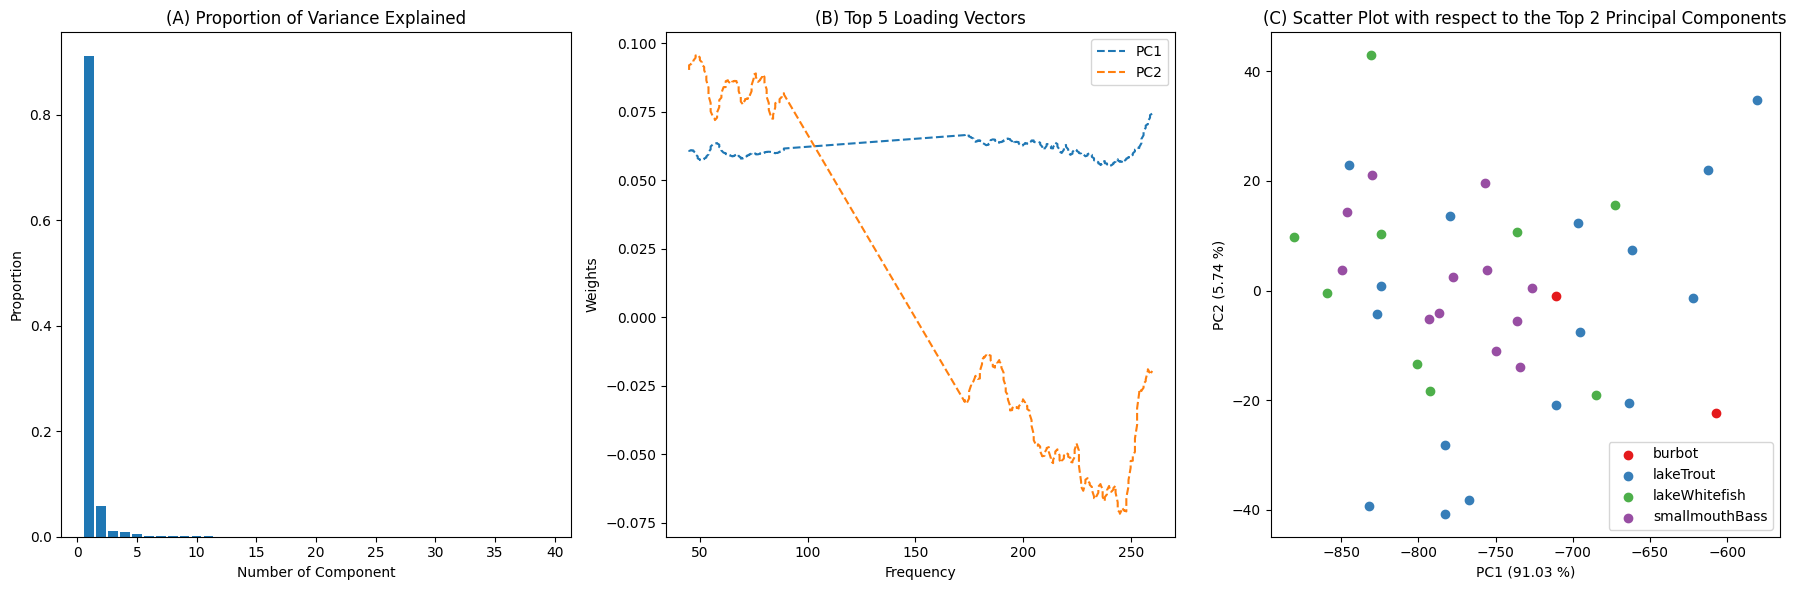

In [148]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
## Scree plot
ax1.bar(PVE.Component, PVE.Variance)
ax1.set_title("(A) Proportion of Variance Explained")
ax1.set_xlabel("Number of Component")
ax1.set_ylabel("Proportion")

## Loading Vectors
ax2.plot(V2Frame["Freq"], V2Frame["PC1"], "--", label="PC1")
ax2.plot(V2Frame["Freq"], V2Frame["PC2"], "--", label="PC2")
# ax2.plot(V2Frame["Freq"], pca.components_[2], "--", label="PC2")
# ax2.plot(V2Frame["Freq"], pca.components_[3], "--", label="PC2")
# ax2.plot(V2Frame["Freq"], pca.components_[4], "--", label="PC2")
ax2.set_title("(B) Top 5 Loading Vectors")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Weights")
ax2.legend()

## Biplot
colors = sns.color_palette("Set1", n_colors=4)
zGroup = Z2.groupby('Species')
cmap = dict(zip(Z2.Species.unique(),
                colors))

for name, group in zGroup:
    ax3.scatter(group.PC1, group.PC2, label=name, color=cmap[name])
ax3.legend()
ax3.set_title("(C) Scatter Plot with respect to the Top 2 Principal Components")
ax3.set_xlabel(f"PC1 ({round(PVE.Variance[0]*100, 2)} %)")
ax3.set_ylabel(f"PC2 ({round(PVE.Variance[1]*100, 2)} %)")

plt.tight_layout()
plt.show()

In [143]:
X.mean()

F45      -52.257009
F45.5    -52.083931
F46      -51.912091
F46.5    -51.441448
F47      -51.320777
            ...    
F258     -38.121533
F258.5   -37.773255
F259     -37.307532
F259.5   -37.359297
F260     -37.315312
Length: 265, dtype: float64

C:\Users\86139\AppData\Local\Temp\ipykernel_7312\3209154194.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Component', y='Variance', data=PVE[:10], palette='viridis')  # Limiting to the first 10 components


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

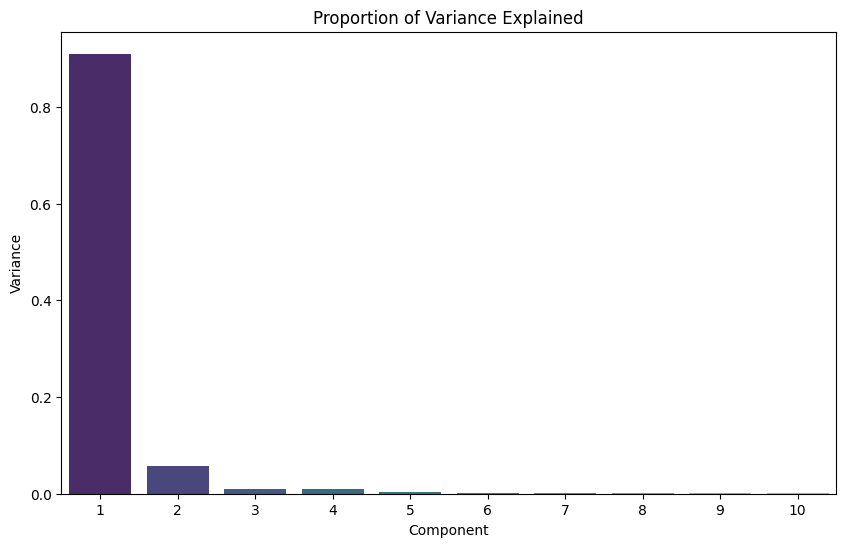

In [31]:
# Creating the scree plot
# fig, ax = plt.subplots()
plt.figure(figsize = (10,6))
sns.barplot(x='Component', y='Variance', data=PVE[:10], palette='viridis')  # Limiting to the first 10 components
plt.title('Proportion of Variance Explained')
plt.set_xlabel('Principal Component')
plt.set_ylabel('Variance')
plt.yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.show()

In [ ]:
pveList = pca.explained_variance_ratio_.tolist()

'PC 1 86.02%'

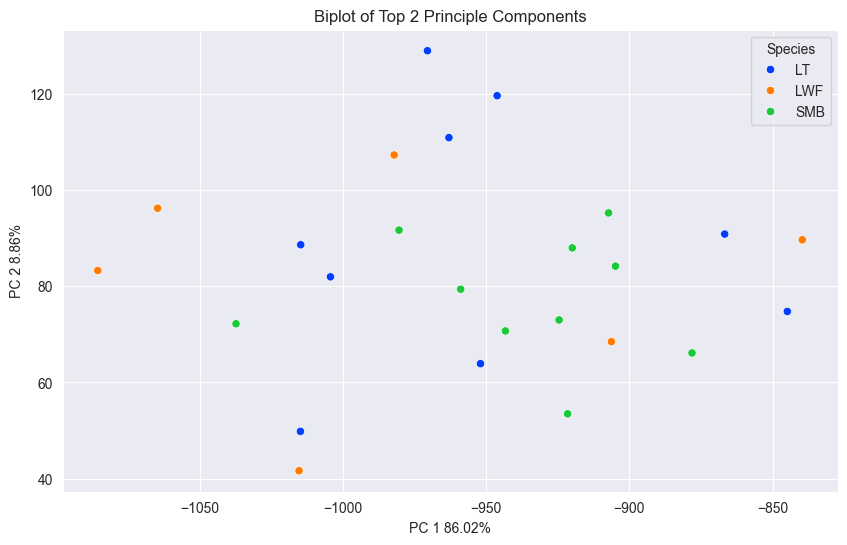

In [ ]:
## Create Biplot
plt.figure(figsize = (10,6))
sns.scatterplot(data = Z2, x='PC1', y='PC2', hue = "Species", palette='bright')  # Limiting to the first 10 components
plt.title('Biplot of Top 2 Principle Components')
plt.xlabel(f'PC 1 {pveList[0]*100:.2f}%')
plt.ylabel(f'PC 2 {pveList[1]*100:.2f}%')
plt.show()
# PVE[:10]

In [ ]:
# Create Pairplot with marginal distribution histograms
V3 = pca.components_[:3,]
Z3 = X @ V3.T
Z2.rename(columns={0: "PC1", 1: "PC2"}, inplace=True)
Z3["Species"] = Z3.index.str.extract(pat=r'([A-Z]+)').squeeze().tolist()

<Figure size 1000x1000 with 0 Axes>

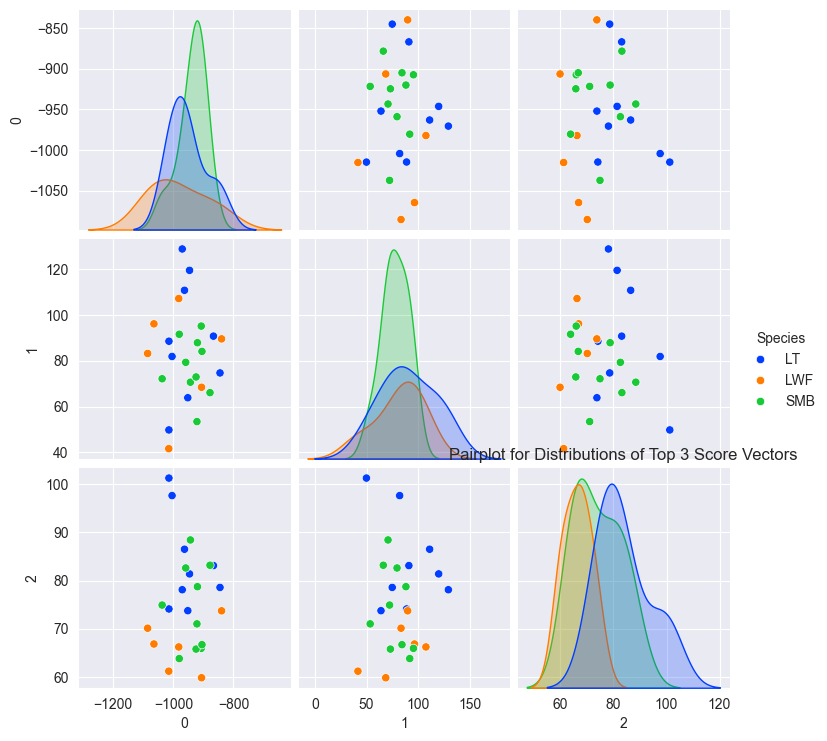

In [ ]:
plt.figure(figsize = (10,10))
sns.pairplot(Z3, hue = "Species", palette='bright')
plt.title('Pairplot for Distributions of Top 3 Score Vectors')
plt.show()

# 6. PCA on Un-averaged TS Data

In [168]:
edaFreq.head()

,fishNum,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
0,BUR001,-38.814772,-38.830886,-38.890894,-38.620250,-38.722318,-38.564741,-38.539975,-38.510200,-38.407615,...,-35.300338,-32.164655,-28.532551,-26.435389,-24.920566,-24.920197,-26.182344,-23.195921,-20.935514,-19.696880
1,BUR001,-44.603438,-42.725789,-41.198087,-39.672310,-38.792759,-37.935088,-37.488491,-37.307162,-37.280499,...,-26.214342,-23.973700,-22.102660,-21.368435,-21.159299,-23.350612,-33.865220,-22.276959,-17.447966,-16.242912
2,BUR001,-52.359911,-54.653565,-53.172086,-50.974915,-49.548376,-48.066730,-47.039243,-46.487134,-46.300204,...,-26.822800,-24.543620,-22.987749,-22.066686,-20.416864,-18.283792,-15.914689,-12.739604,-12.235742,-12.369379
3,BUR001,-41.738457,-41.201149,-40.828811,-40.455050,-40.965566,-41.857992,-43.550850,-45.941199,-49.106147,...,-30.783048,-29.365064,-28.257164,-26.975177,-24.021663,-20.363500,-17.227954,-14.199619,-14.372365,-14.995698
4,BUR001,-40.327526,-40.770263,-41.374854,-41.825099,-42.891517,-43.998378,-45.545856,-47.296758,-48.872338,...,-25.980872,-25.457917,-24.962387,-24.180562,-21.715426,-18.732545,-16.442745,-14.235711,-15.039336,-15.783071


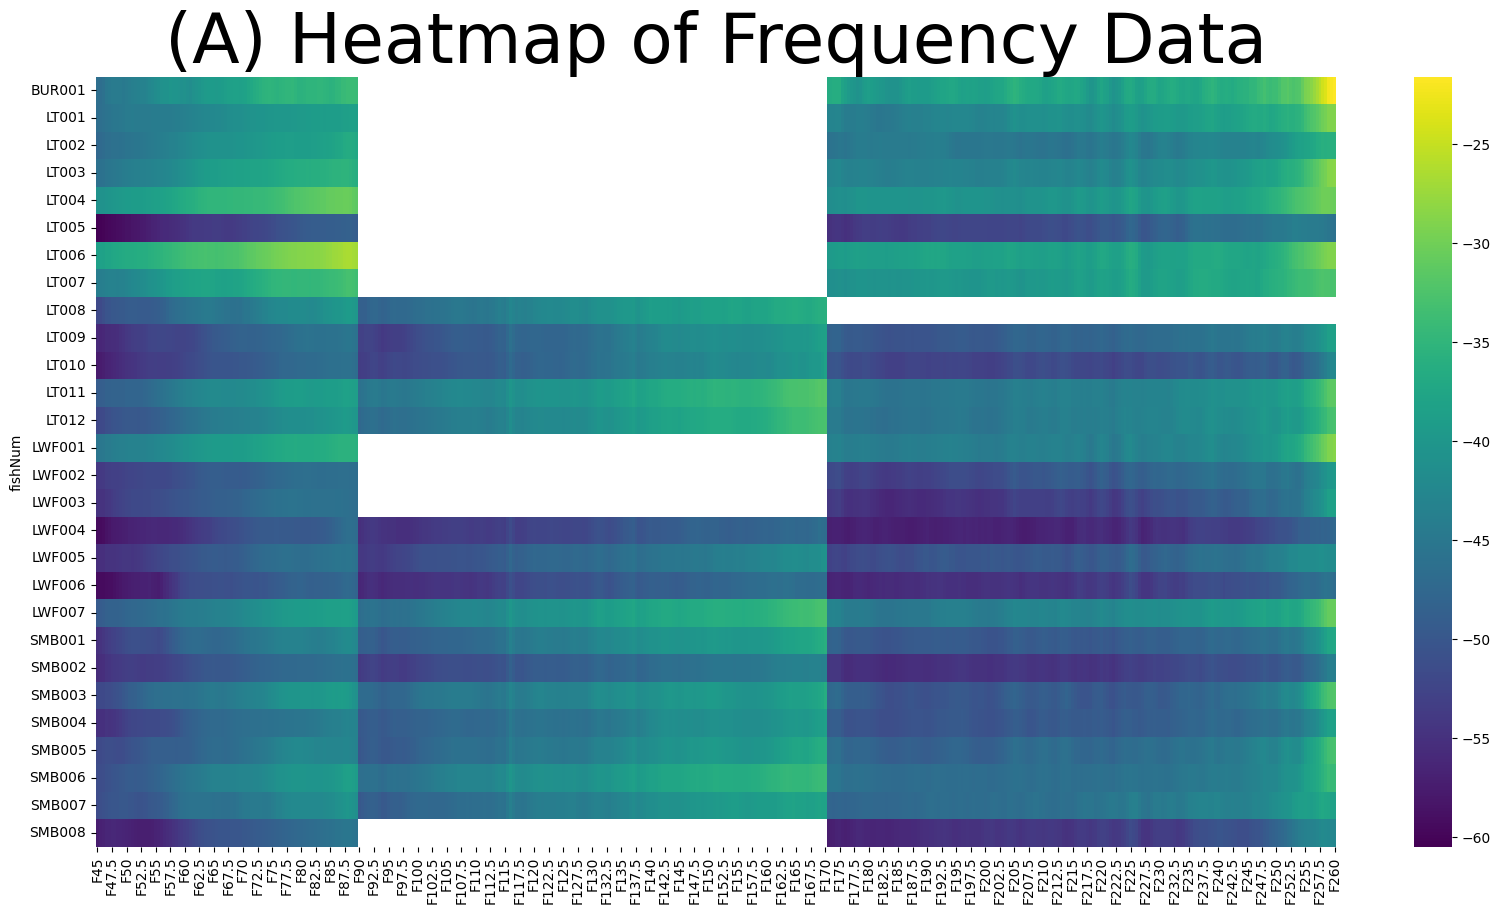

In [172]:
# Assuming `data` is your 40000 x 400 DataFrame
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(edaFreqSmry, cmap="viridis")
plt.title("(A) Heatmap of Frequency Data", fontsize=50)
plt.show()

In [174]:
edaFreqBySpecies = edaData[["species"] + allFreq].groupby("species").mean().reset_index()

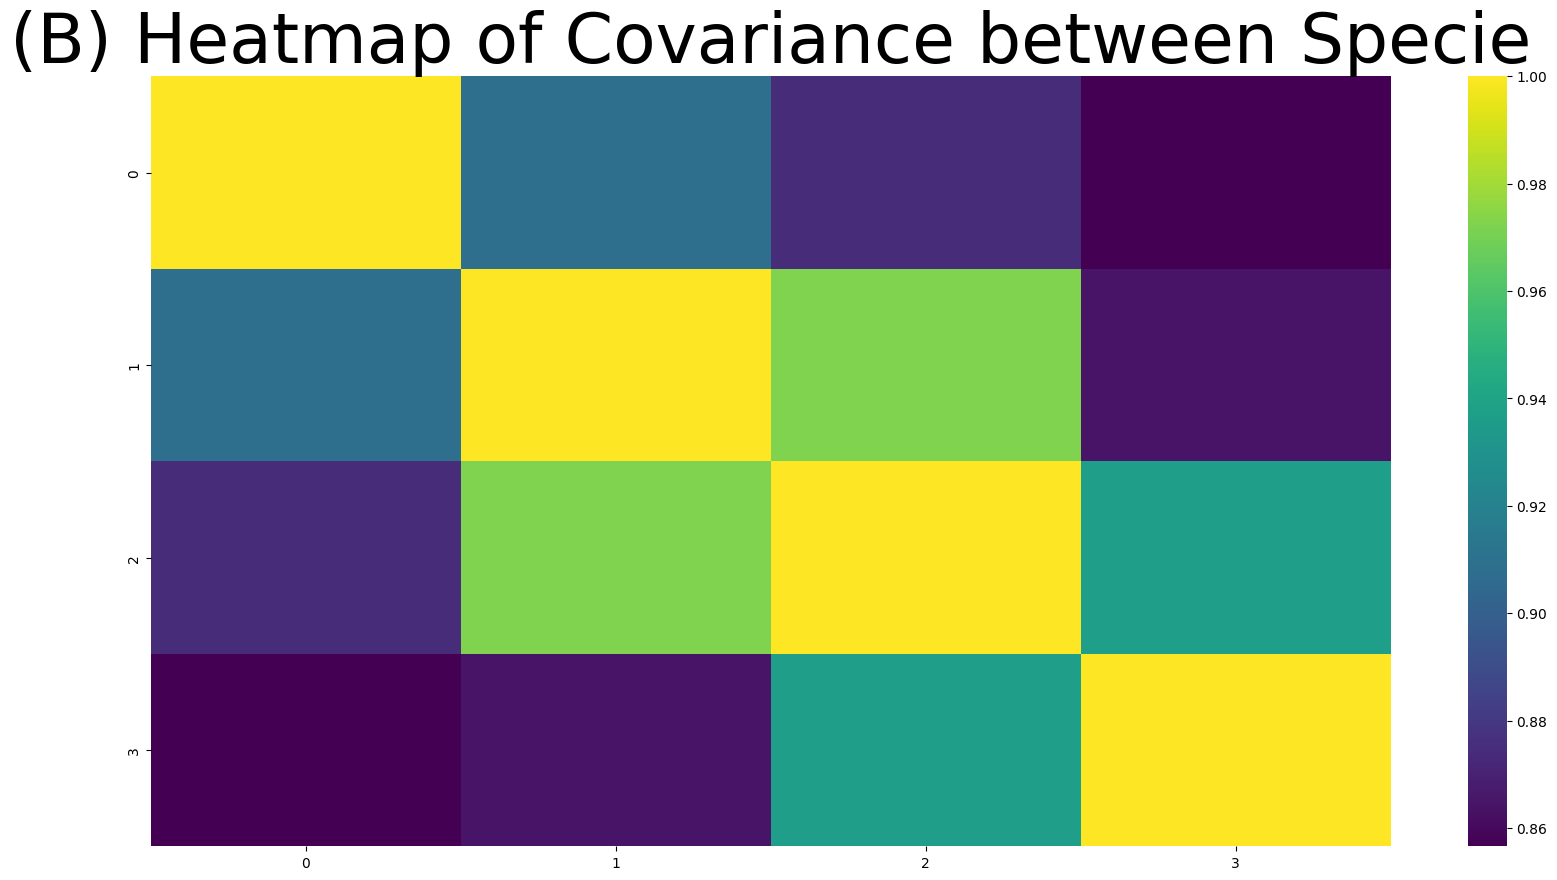

In [185]:
interSpeciesCovariance = edaFreqBySpecies[allFreq].T.corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(interSpeciesCovariance, cmap="viridis")
plt.title("(B) Heatmap of Covariance between Specie", fontsize=50)
plt.show()

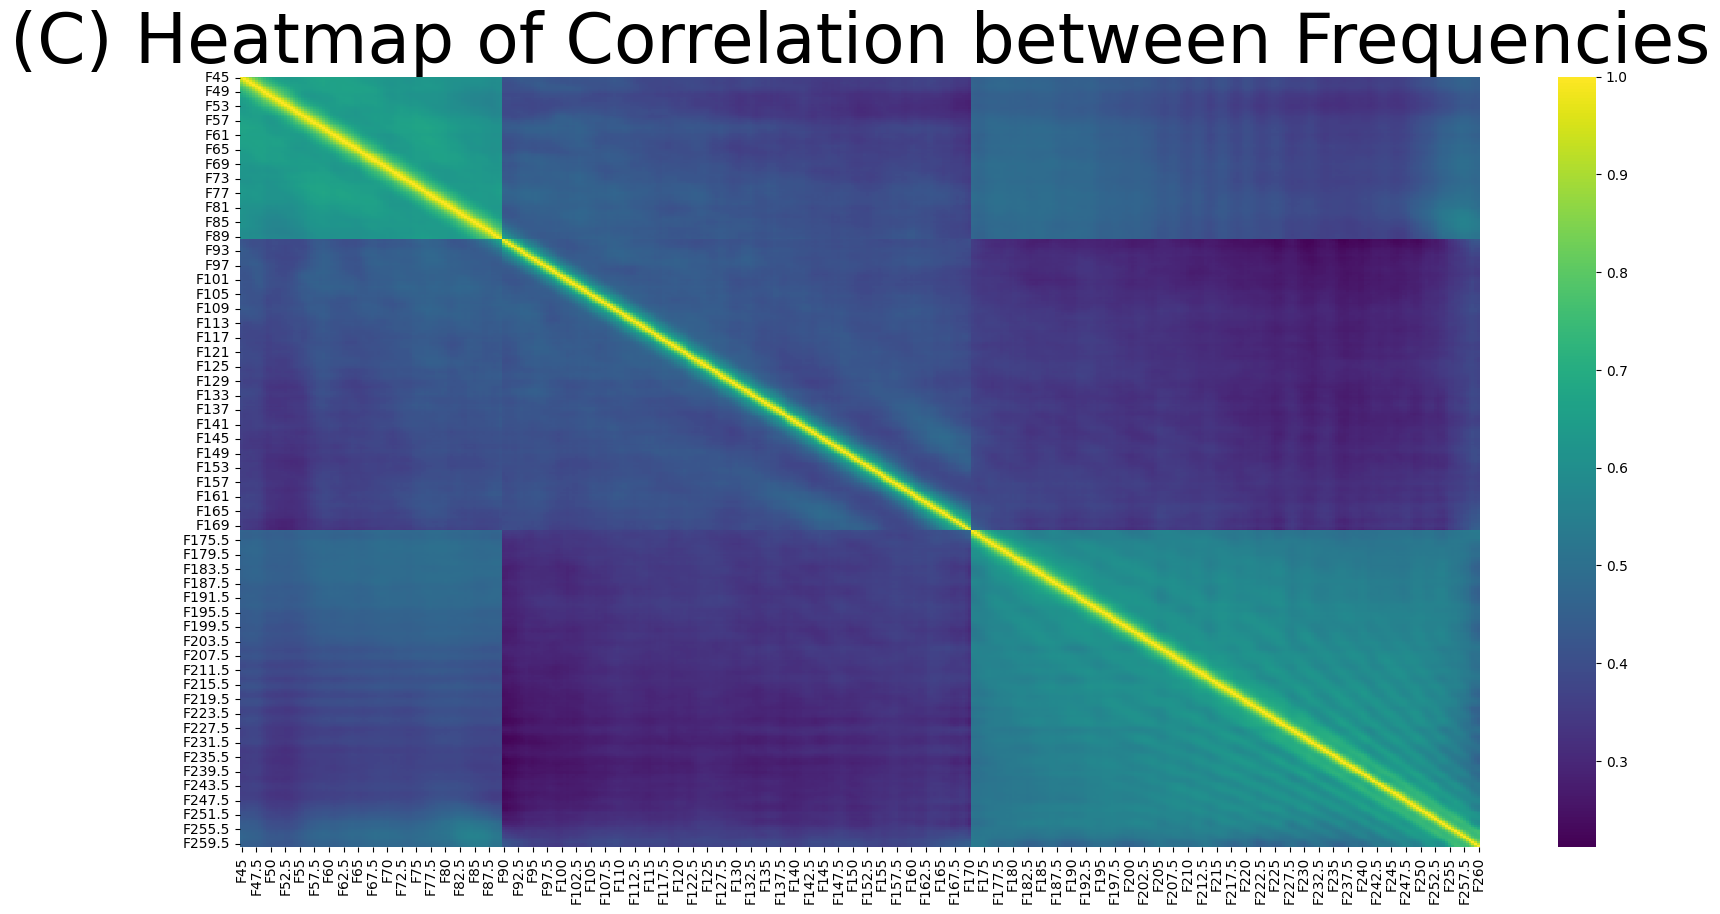

In [184]:
interFreqCovariance = edaData[allFreq].corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(interFreqCovariance, cmap="viridis")
plt.title("(C) Heatmap of Correlation between Frequencies", fontsize=50)
plt.show()

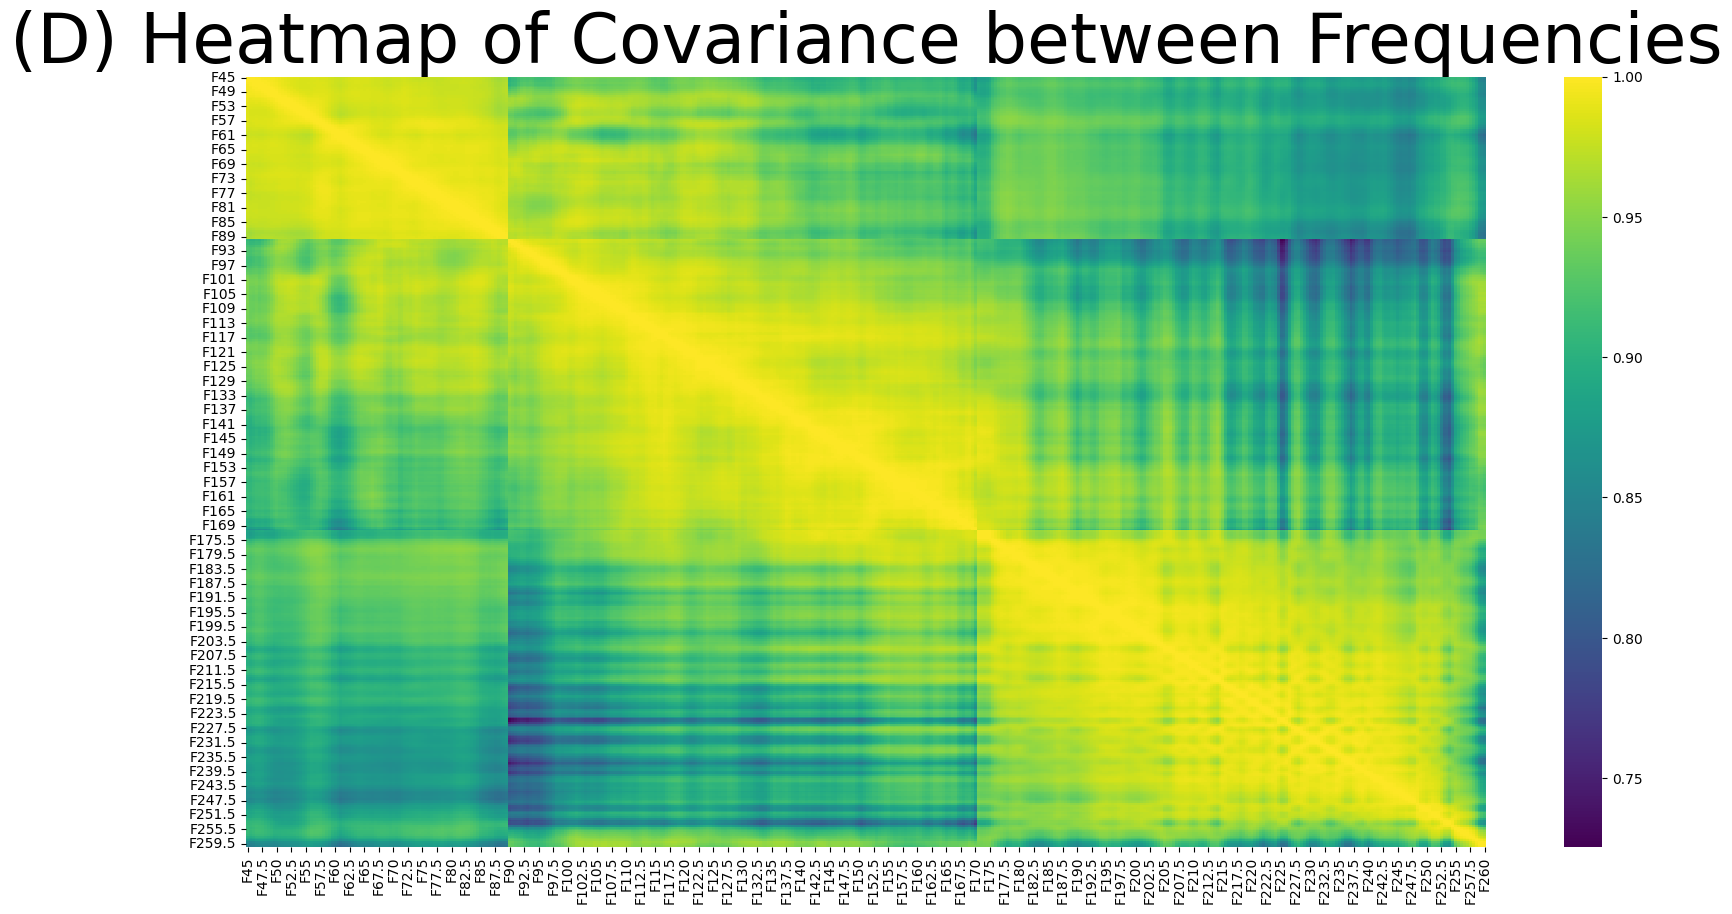

In [183]:
interFreqCovariance = edaFreqSmry.corr()

plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
sns.heatmap(interFreqCovariance, cmap="viridis")
plt.title("(D) Heatmap of Covariance between Frequencies", fontsize=50)
plt.show()

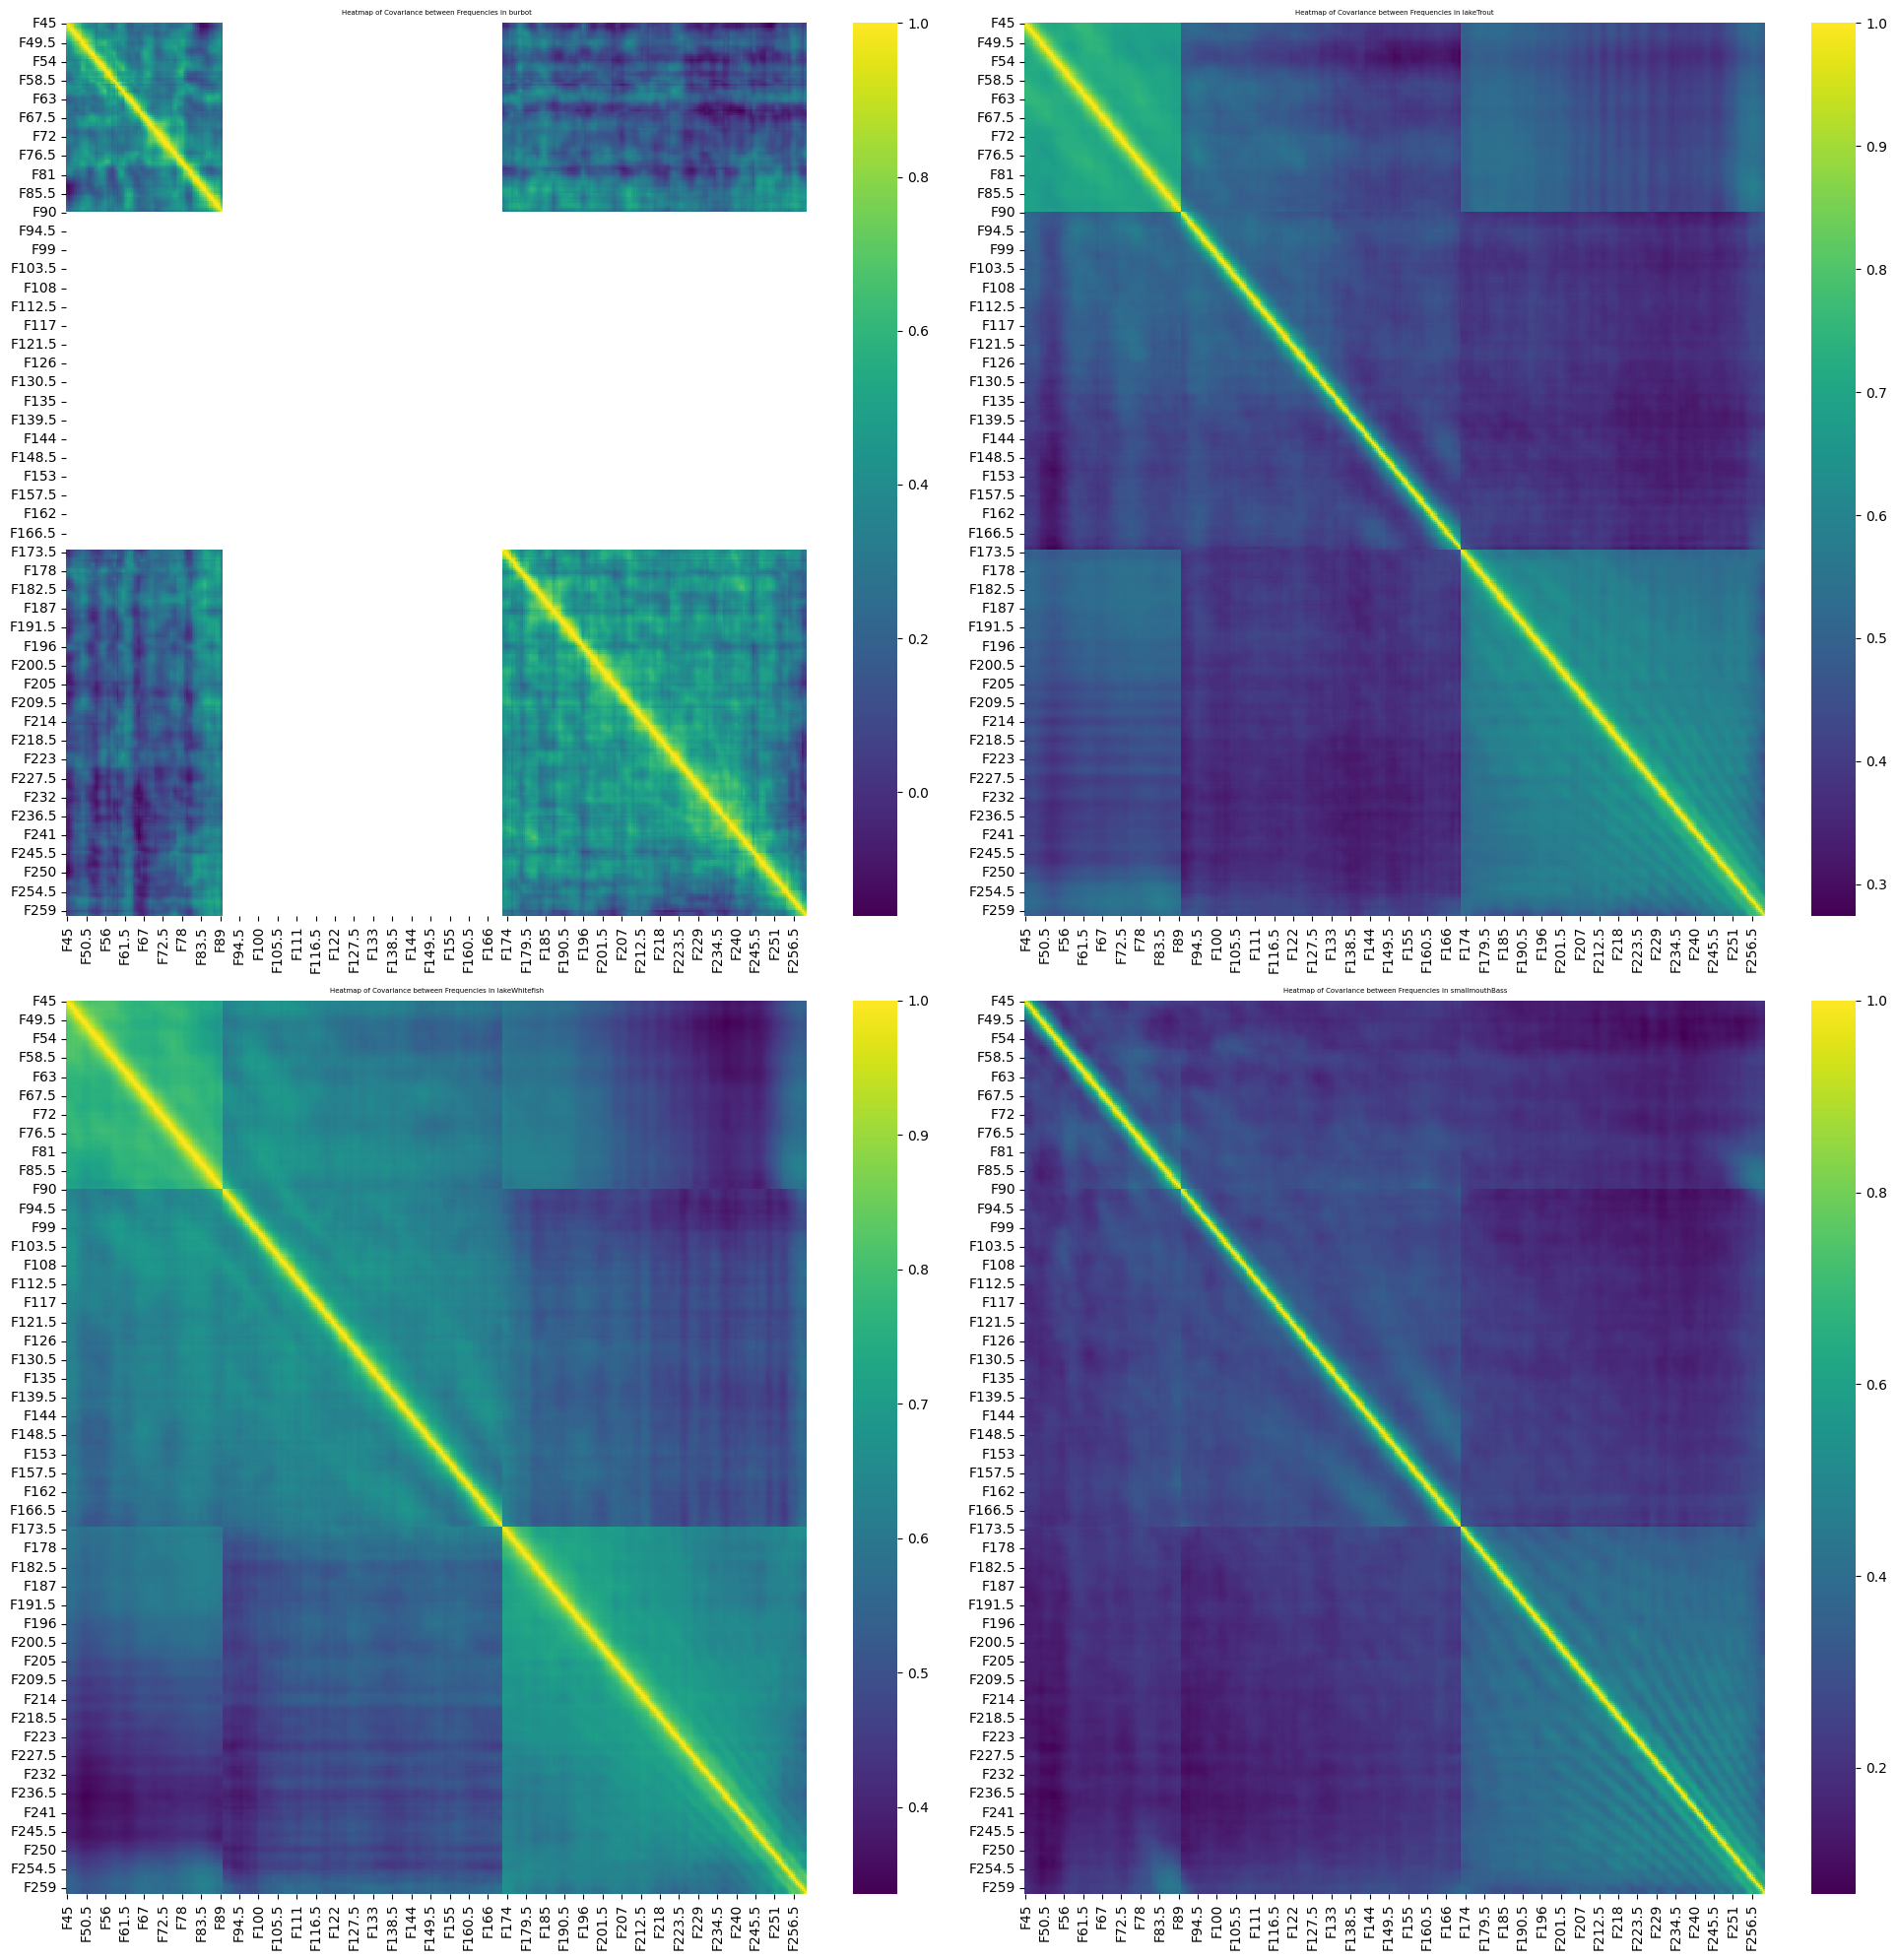

In [61]:
freqGroupbySpecies = edaData[["species"] + allFreq].groupby("species")

fig, ax = plt.subplots(2,2, figsize=(20, 20))
i = 0
for name, group in freqGroupbySpecies:
    groupFreqCorr = group[allFreq].corr()
    sns.heatmap(groupFreqCorr, cmap="viridis", ax = ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"Heatmap of Covariance between Frequencies in {name}", fontsize=5)
    i += 1

fig.tight_layout()
plt.show()

In [7]:
avgfreqGroupbyFishNum = edaData[["fishNum"] + allFreq].groupby("fishNum").mean()
avgfreqGroupbyFishNum.Species = edaFreqSmry.species
for name, group in avgfreqGroupbyFishNum.groupby("species"):
    groupFreqCorr = group[allFreq].corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(groupFreqCorr, cmap="viridis")
    plt.title(f"Heatmap of Covariance between Frequencies in {name}", fontsize=30)
    plt.show()

NameError: name 'allFreq' is not defined

In [41]:
def thresholdImpute(df):
    """
    Impute missing values in a DataFrame.
    For each column, if there are more than 50% missing values, drop that column.
    Otherwise, impute the column mean to the missing values.
    Skip columns with no missing values.
    
    :param df: pandas DataFrame
    :return: pandas DataFrame with imputed values
    """
    threshold = 0.5 * len(df)
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count == 0:
            continue
        elif missing_count > threshold:
            df.drop(columns=[col], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

# Example usage
# df_imputed = impute_missing_values(proc_data)

## Group wide PCA
def speciesWidePCA(df, species, freqVar):
    """
    Perform PCA on all individuals in a given species
    :param df: a DataFrame with column being the fish number and the rest being frequencies
    :param groupVar: a string, the column name of the group variable
    :param freqVar: a list of strings, the column names of the frequencies
    :return: a DataFrame with the first 2 principle components
    """
    groupFreq = df.loc[df.species == species, freqVar]
    groupFreq = thresholdImpute(groupFreq)

    groupFreqStandardized = StandardScaler().fit(groupFreq).transform(groupFreq)
    print("Stenadardizer set up")
    pca = PCA(n_components=10, svd_solver="full")
    pca.fit(groupFreqStandardized)

    V3 = pca.components_[:3]  # the first three principle vectors
    propExplained = pca.explained_variance_ratio_

    # Z3 = pd.DataFrame(groupFreq @ V3.T)  # The first three score vectors
    # Z3.rename(columns={0: "PC1", 1: "PC2", 3: "PC3"}, inplace=True)

    return {"PC": V3.T, "Scree": propExplained, "Freq": groupFreq.columns}


In [11]:
edaFreqRaw= edaData[["fishNum", "species"] + allFreq]

# from sklearn.impute import SimpleImputer

# X = edaFreqRaw.loc[edaFreqRaw.species == "burbot", allFreq]
# X = thresholdImpute(X)

# # X.dropna(axis=1, how="any", inplace=True)
# # X.dropna(axis=0, how="any", inplace=True)

# X_std = StandardScaler().fit(X).transform(X)

# pca = PCA(n_components=10, svd_solver="full")
# pca.fit(X_std).components_

# speciesWidePCA(edaFreqRaw, "lakeWhiteFish", allFreq)

# thresholdImpute()
edaFreqRaw.loc[edaFreqRaw.species == "lakeWhitefish", allFreq]

# edaFreqRaw.species.unique()

,F45,F45.5,F46,F46.5,F47,F47.5,F48,F48.5,F49,F49.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
34070,-43.041003,-44.751973,-46.025598,-46.687045,-47.514034,-48.015668,-48.556521,-48.986269,-49.258000,-49.534569,...,-46.434278,-52.592668,-57.893314,-45.730178,-39.715779,-35.660150,-33.314453,-31.784946,-32.695303,-34.469221
34071,-53.686808,-54.652579,-54.737904,-53.955950,-53.233007,-52.304026,-51.639066,-51.099241,-50.607719,-50.266208,...,-42.242429,-41.415797,-40.979355,-41.424954,-42.913627,-47.103452,-52.500263,-43.839588,-40.045462,-38.210549
34072,-64.458895,-59.920018,-56.705910,-54.153598,-52.644657,-51.535467,-50.965641,-50.600011,-50.276514,-50.051388,...,-47.229541,-46.805822,-46.010562,-45.654610,-45.992290,-47.948325,-53.955026,-53.070751,-46.475278,-43.649118
34073,-65.723700,-82.383884,-65.111749,-59.147715,-55.938062,-53.767209,-52.460596,-51.556516,-50.835448,-50.320434,...,-53.526810,-54.483508,-51.631481,-50.317495,-49.791610,-49.317731,-49.363267,-49.342482,-49.489137,-48.927663
34074,-61.841231,-73.983278,-67.125803,-59.011987,-55.208612,-52.853710,-51.544256,-50.728798,-50.135638,-49.753163,...,-43.399408,-41.251556,-40.171768,-40.299469,-41.334175,-43.385965,-45.486452,-44.744324,-45.049331,-47.741071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43482,-44.391902,-44.264492,-44.274938,-43.865401,-43.680187,-43.112309,-42.652132,-42.215010,-41.735761,-41.343294,...,-22.562274,-21.532622,-20.866185,-20.026698,-19.198451,-18.242727,-17.010627,-15.945839,-16.169098,-17.555883
43483,-42.068143,-42.160266,-42.347190,-42.207200,-42.377810,-42.224618,-42.144120,-42.023118,-41.817238,-41.660403,...,-23.263176,-22.149806,-22.148688,-22.866397,-24.205849,-25.244308,-24.050484,-20.920548,-18.927819,-18.169407
43484,-40.614506,-40.662545,-40.797419,-40.614895,-40.752549,-40.639117,-40.640908,-40.600445,-40.442677,-40.275088,...,-29.308100,-26.498094,-23.355015,-21.046748,-19.586532,-18.821563,-18.806654,-19.155009,-20.107761,-20.396143
43485,-38.820058,-38.822827,-38.933621,-38.731102,-38.843040,-38.747715,-38.834709,-38.952503,-39.009858,-39.080136,...,-24.093722,-22.770743,-22.471410,-23.057140,-24.410453,-27.200991,-33.963774,-32.152050,-25.907044,-23.588574


In [51]:
allSpecies = ["burbot", "lakeTrout", "lakeWhitefish", "smallmouthBass"]
listOfPC = pd.DataFrame({"Species": [], "PC1": [], "PC2": [], "PC3": []})
listOfProp = pd.DataFrame({"Species": [], "Proportion": []})
# listOfScore = pd.DataFrame({"Species": [], "Z1": [], "Z2": [], "Z3": []})

for species in allSpecies:
    speciesPCA = speciesWidePCA(edaFreqRaw, species, allFreq)

    pcFrame = pd.DataFrame(speciesPCA["PC"], columns=["PC1", "PC2", "PC3"])
    pcFrame["Species"] = species
    pcFrame["Freq"] = speciesPCA["Freq"]
    listOfPC = pd.concat([listOfPC, pcFrame], axis=0)

    screeFrame = pd.DataFrame(speciesPCA["Scree"], columns=["Proportion"])
    screeFrame["Species"] = species
    screeFrame["Component"] = screeFrame.index + 1
    listOfProp = pd.concat([listOfProp, screeFrame], axis=0)

    
    # scoreFrame = pd.DataFrame(speciesPCA["Score"], columns=["Z1", "Z2", "Z3"])
    # scoreFrame["Species"] = species
    # listOfScore = pd.concat([listOfScore, scoreFrame], axis=0)

Stenadardizer set up


C:\Users\86139\AppData\Local\Temp\ipykernel_17760\217204414.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Stenadardizer set up
Stenadardizer set up


C:\Users\86139\AppData\Local\Temp\ipykernel_17760\217204414.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Stenadardizer set up


In [52]:
listOfPC.Freq = listOfPC.Freq.str.extract(r'(\d+)', expand=False).astype(int)

In [ ]:
listOfProp

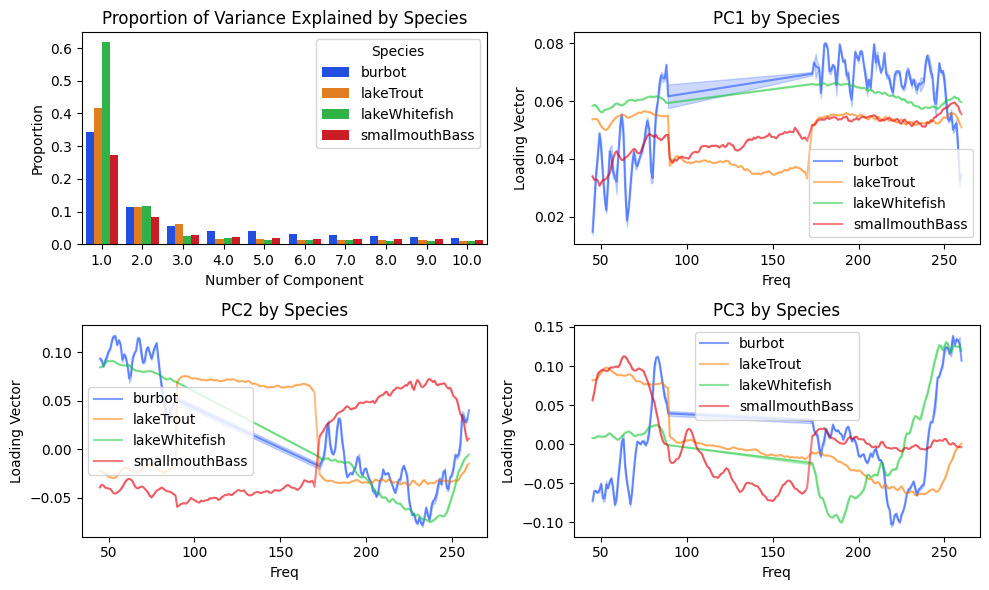

In [58]:
fig, ax1 = plt.subplots(2, 2, figsize=(10, 6))

# Plot the clustered bar plot
sns.barplot(data=listOfProp, x='Component', y='Proportion', hue='Species', palette='bright', ax=ax1[0, 0])
ax1[0, 0].set_title("Proportion of Variance Explained by Species")
ax1[0, 0].set_xlabel("Number of Component")
ax1[0, 0].set_ylabel("Proportion")


# Plot the first component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC1',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[0,1])
ax1[0, 1].set_title("PC1 by Species")
ax1[0, 1].set_xlabel("Freq")
ax1[0, 1].set_ylabel("Loading Vector")
ax1[0, 1].legend()
    

# Plot the 2nd component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC2',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[1, 0])
ax1[1, 0].set_title("PC2 by Species")
ax1[1, 0].set_xlabel("Freq")
ax1[1, 0].set_ylabel("Loading Vector")
ax1[1, 0].legend()


# Plot the 2nd component of each species on the second subplot
sns.lineplot(data=listOfPC, x='Freq', y='PC3',
            hue='Species', palette='bright', alpha=0.5,
            ax=ax1[1, 1])
ax1[1, 1].set_title("PC3 by Species")
ax1[1, 1].set_xlabel("Freq")
ax1[1, 1].set_ylabel("Loading Vector")
ax1[1, 1].legend()


plt.tight_layout()
plt.show()

In [64]:
listOfPC.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/PCbySpecies.csv")
listOfProp.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/PropbySpecies.csv")

In [65]:
edaFreqSmry.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaFreqSmry.csv")
edaFreqRaw.to_csv("C:/Users/86139/Desktop/FishTetherExperiment/ProcessedData/edaFreqRaw.csv")